# Countermeasure to SPA on RSA
In the previous notebook series you learned how to crack different types of encryption algorithms. Now it's time to think about how to implement the algorithms in a way that prevents people for using those attacks succesfully.
In this notebook you will learn how to take a simple countermeasure against a simple power analysis attack on the RSA encryption system.

**Goals:**
* Learn how to "invent" a countermeasure against a SPA against RSA.
* Implement that countermeasure in the source code. 
* Try a SPA on our newly implemented SPA and watch it fail.

#### Prerequisites
- [x] *0_series* notebooks 
- [x] *1_series* notebooks
- [x] *2_series* notebooks

## Coming up with a simple countermeasure

Let's shortly cover how and why an SPA works. The SPA takes advantage of the fact that in order for the target to perform an exponential operation it goes through a for-loop. When the bit of the exponent is a `1` an extra instruction will be performed by the microcontroller. Lookiing at the power consumtion of the target we can find out when a pass through the for-loop starts. By measuring the time between each pass we can seperate the passes into two groups: passes through the for-loop that are short and passes that take longer. If a pass through the for-loop was long then the bit provided by the exponential number was a `1`. Similarly a short pass corresponds to a `0` bit. The exponent that is used is the secret key of the endcryption/decryption algorithm. By analysing the powerconsumption we could directly recover the secret key.

Now you need to try and figure out how we can implement a countermeasure. First of all let's define the place of weakness in the implementation: the different length of each pass through the for-loop. So our objective will be to make each pass through the for-loop the same length regardles of the bitvalue of the exponent. As we have seen in notebook `1_B - Attack on RSA` there is an `if-statement` inside the for-loop that runs extra code:
```C
if(t & (1<<(8-1))){
    bigint_mul_u(&res, &res, &base);
    bigint_reduce(&res, r);
}
```
Now there is quiet a simple solution to making the passes the same length. I'll let you think about it for a couple seconds...

...

...

...

...

...

Maybe we can just add an `else` to the `if-statement` so that regardless of the value of the bit some instructions will be performed. Now we only need to figure out what instruction we should perform there. The most obvious thing would be to do perform the exact same instrustions as in the `if-statement`. Since what we do in the `else` statement has nothing to do with workings of RSA itself we will need to use some dummy data however. We could use some randomly generated values used in the instructions, but to make it resemble the `if` part even more we can use the exact same values. We have to make sure to use copied values because of what we said earlier.
And voila, you successfully "invented" a countermeasure to SPA. The next step is to implement the changes in the source code and test our idea.

## Implementing the countermeasure in the source code

Firstly, we will attack the RSA without the countermeasure in order to compare our results later on. Run the next couple of codeblocks to compile the firmware, program the target and run the attack. (To make it easy for you to perform the attack seen in `1_B - Attack on RSA` we turned it into a fuction where the parameters are the different values you needed to tweak to be succesfull)
As before make sure the faulty fuctions are commented out in the source code:
```C
    #if SS_VER != SS_VER_2_0
    //simpleserial_addcmd('1', 0,  sig_chunk_1);
    //simpleserial_addcmd('2', 0,  sig_chunk_2);
    #endif
```
Click [here](http://localhost:8888/edit/chipwhisperer/hardware/victims/firmware/simpleserial-rsa/simpleserial-rsa.c) to open the source file. (don't forget to save)

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'AVRCRYPTOLIB'

In [2]:
%run "Setup_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-rsa
make PLATFORM=$1 CRYPTO_TARGET='AVRCRYPTOLIB'

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-rsa-CWLITEXMEGA.hex
rm -f -- simpleserial-rsa-CWLITEXMEGA.eep
rm -f -- simpleserial-rsa-CWLITEXMEGA.cof
rm -f -- simpleserial-rsa-CWLITEXMEGA.elf
rm -f -- simpleserial-rsa-CWLITEXMEGA.map
rm -f -- simpleserial-rsa-CWLITEXMEGA.sym
rm -f -- simpleserial-rsa-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-rsa.s simpleserial-rsa-xmega.s simpleserial-rsa-arm.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s rsa_basic.s bigint.s
rm -f -- simpleserial-rsa.d simpleserial-rsa-xmega.d simpleserial-rsa-arm.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d rsa_basic.d bigint.d
rm -f -- simpleserial-rsa.i simpleserial-rsa-xmega.i simpleserial-rsa-arm.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i rsa_basic.i bigint.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free so

simpleserial-rsa-xmega.c: In function â€˜get_ptâ€™:
simpleserial-rsa-xmega.c:217:19: warning: initialization from incompatible pointer type [-Wincompatible-pointer-types]
 #define ENCRYPTED encrypted_x
                   ^
simpleserial-rsa-xmega.c:314:25: note: in expansion of macro â€˜ENCRYPTEDâ€™
     const bigint_t* a = ENCRYPTED;
                         ^
.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [5]:
cw.program_target(scope, prog, '../../chipwhisperer/hardware/victims/firmware/simpleserial-rsa/simpleserial-rsa-CWLITEXMEGA.hex')

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 12207 bytes


In [6]:
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 24000

%matplotlib notebook
import matplotlib.pylab as plt

def capture_RSA_trace(scope, target, text):
    # arm the CW scope to start recording power consumption
    scope.arm()
    # send the input text to the target
    target.simpleserial_write('p', text)
    # capture a power measurement
    ret = scope.capture()
    if ret:
        return None
    target.simpleserial_wait_ack()
    # all 24000 traces are collected
    
    # return the array of power measurements
    return scope.get_last_trace()

text = bytearray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0x0B, 0x04])
# 0xB04 = 0b1011 0000 0100
trace = capture_RSA_trace(scope, target, text)

In [7]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

def SAD(array1, array2):
    diff = array1-array2
    return np.sum(abs(diff))
    
def sad_sweep(trace,signature):
    sad_result = np.array([])
    for i in range(len(trace)-len(signature)+1):
        sad_value = SAD(signature, trace[i:i+len(signature)])
        sad_result = np.append(sad_result,sad_value)
    return sad_result

def spa_attack(trace,start_index,end_index,threshold,threshold2,final_bit_guess):
    plt.figure()
    plt.plot(trace, 'r')
    plt.show()
    signature = trace[start_index:end_index]
    sad_sweep_results = sad_sweep(trace,signature)
    plt.figure()
    plt.plot(sad_sweep_results, 'b')
    plt.show()
    positions = np.array([])

    for i in range(len(sad_sweep_results)-1):
        if(sad_sweep_results[i] < threshold):
            positions = np.append(positions,i)

    intervals = []
    for i in range(0, len(positions)-1):
        interval = positions[i+1] - positions[i]
        intervals.append(interval)
    plt.figure()
    plt.plot(intervals, range(0, len(intervals)), 'or')
    plt.grid(True)
    plt.title('A Learned Comparison of RSA Execution Time')
    plt.ylabel('Processing Bit Number')
    plt.xlabel('Time Delta (based on SAD Match)')
    plt.show()
    
    key = ""

    for i in range(0, len(intervals)):
        if intervals[i] > threshold2:
            key += "1"
        else:
            key += "0"
    key += final_bit_guess # maybe this is not correct but it is only 1 bit. So if '0' doesn't work the right answer is '1'

    print(key)
    print("I think the real key is : " + hex(int(key,2)))

<IPython.core.display.Javascript object>


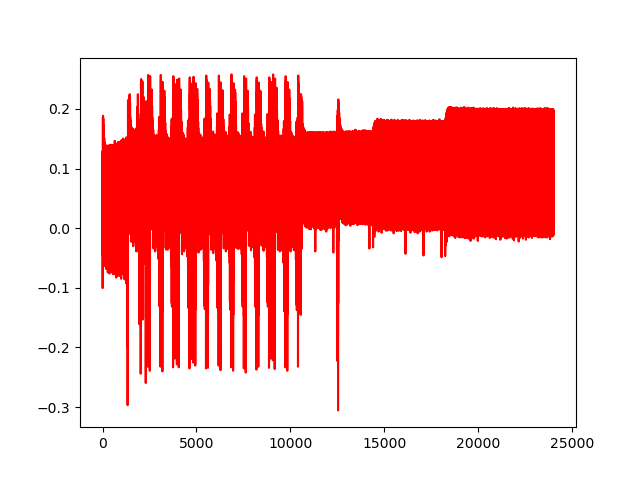

<IPython.core.display.Javascript object>


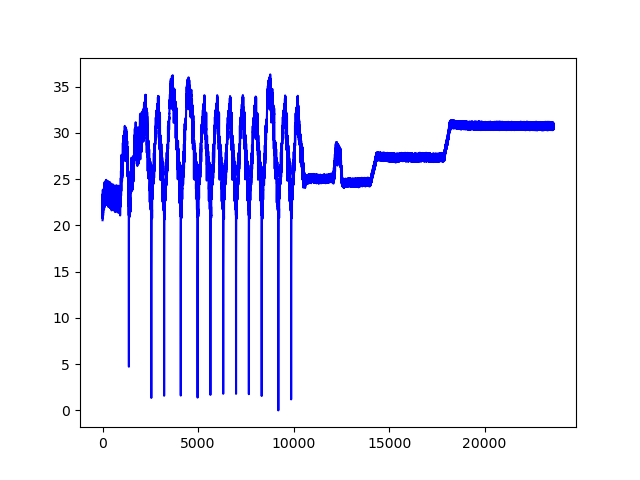

<IPython.core.display.Javascript object>


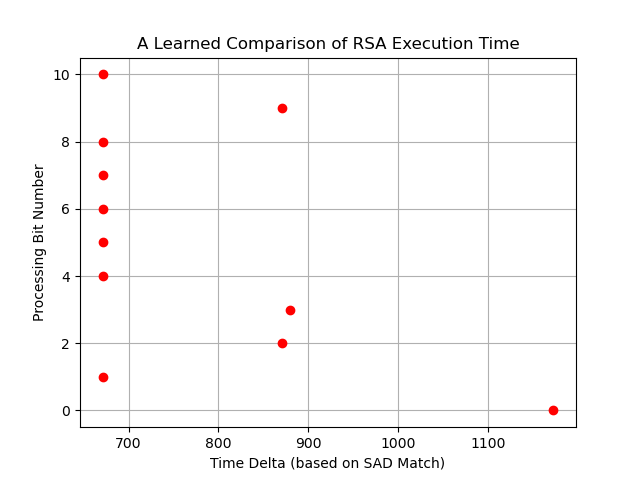

101100000100
I think the real key is : 0xb04
The real key was: CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 0b 04')


In [8]:
spa_attack(trace,9200,9600,10,800,"0")
print("The real key was: "+str(text))

Ok now that we see our attack still works, let's modify the source code the prevent us from cracking it! Open the correct source file by clicking [here](http://localhost:8888/edit/chipwhisperer/hardware/victims/firmware/simpleserial-rsa/simpleserial-rsa-xmega.c). Modify the file so that is looks like the code below. The edited parts are wrapped by the comments `//START EDIT` and `//END EDIT`:
```C
uint8_t get_pt(uint8_t * pt, uint8_t len)
{
	uint8_t flag = 0;

    const bigint_t* r = &(priv_key.components[0]);
    const bigint_t* a = ENCRYPTED;

    bigint_t res, base;
    
	bigint_word_t t, base_b[MAX(a->length_B,r->length_B)], res_b[r->length_B*2];
	uint16_t i;
	uint8_t j;
	res.wordv = res_b;
	base.wordv = base_b;
	bigint_copy(&base, a);
	bigint_reduce(&base, r);
	res.wordv[0]=1;
	res.length_B=1;
	res.info = 0;
	bigint_adjust(&res);
    
    //START EDIT
    bigint_t r2;
    bigint_t res2;
    bigint_t base2;
    bigint_copy(&base2, &base);
    bigint_copy(&res2, &res);
    const bigint_t* r2pt = &(r2);
    //END EDIT

    trigger_high();


	for(i = 0; i < 16; i++) {

		//t = exp->wordv[i - 1];
        t = pt[i];

		for(j=8; j > 0; --j){
			if(!flag){
				if(t & (1<<(8-1))){
					flag = 1;
				}
			}
			if(flag){
				bigint_square(&res, &res);
				bigint_reduce(&res, r);
				if(t & (1<<(8-1))){
					bigint_mul_u(&res, &res, &base);
					bigint_reduce(&res, r);
				}
                //START EDIT
                else{
                    bigint_mul_u(&res2, &res2, &base2);
					bigint_reduce(&res2, r2pt);
                }
                //END EDIT
			}
			t<<=1;
		}
	}

    trigger_low();

    return 0;
}
```

As you can clearly see above, we firsly copy the values that will be used in the `if-statement` into 3 new variables: `res2`,`base2` and `r2pt`. We then later use these dummy variables to execute the same instructions as in the `if` part in the newly created `else` part. The following code blocks recompile the firmware and flash the new RSA onto the target. 
(Again don't forget to save the source file before recompiling)

In [14]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-rsa
make PLATFORM=$1 CRYPTO_TARGET='AVRCRYPTOLIB'

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-rsa-CWLITEXMEGA.hex
rm -f -- simpleserial-rsa-CWLITEXMEGA.eep
rm -f -- simpleserial-rsa-CWLITEXMEGA.cof
rm -f -- simpleserial-rsa-CWLITEXMEGA.elf
rm -f -- simpleserial-rsa-CWLITEXMEGA.map
rm -f -- simpleserial-rsa-CWLITEXMEGA.sym
rm -f -- simpleserial-rsa-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-rsa.s simpleserial-rsa-xmega.s simpleserial-rsa-arm.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s rsa_basic.s bigint.s
rm -f -- simpleserial-rsa.d simpleserial-rsa-xmega.d simpleserial-rsa-arm.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d rsa_basic.d bigint.d
rm -f -- simpleserial-rsa.i simpleserial-rsa-xmega.i simpleserial-rsa-arm.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i rsa_basic.i bigint.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free so

simpleserial-rsa-xmega.c: In function â€˜get_ptâ€™:
simpleserial-rsa-xmega.c:217:19: warning: initialization from incompatible pointer type [-Wincompatible-pointer-types]
 #define ENCRYPTED encrypted_x
                   ^
simpleserial-rsa-xmega.c:314:25: note: in expansion of macro â€˜ENCRYPTEDâ€™
     const bigint_t* a = ENCRYPTED;
                         ^
simpleserial-rsa-xmega.c:358:25: warning: â€˜randomâ€™ may be used uninitialized in this function [-Wmaybe-uninitialized]
                 *random = rand();
                         ^
.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [15]:
cw.program_target(scope, prog, '../../chipwhisperer/hardware/victims/firmware/simpleserial-rsa/simpleserial-rsa-CWLITEXMEGA.hex')

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 12579 bytes


## Attacking our newly implemented code

Finally try to attack the new firmware to find the hidden key. Obviously you need to tweak the parameters of the attack function again using the generated plots. Rerun the attack a couple of times and try some values that will help you crack the key. 

In [16]:
text = bytearray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0x0B, 0x04])
# 0xB04 = 0b1011 0000 0100
trace = capture_RSA_trace(scope, target, text)
#plt.plot(trace, 'r')

<IPython.core.display.Javascript object>


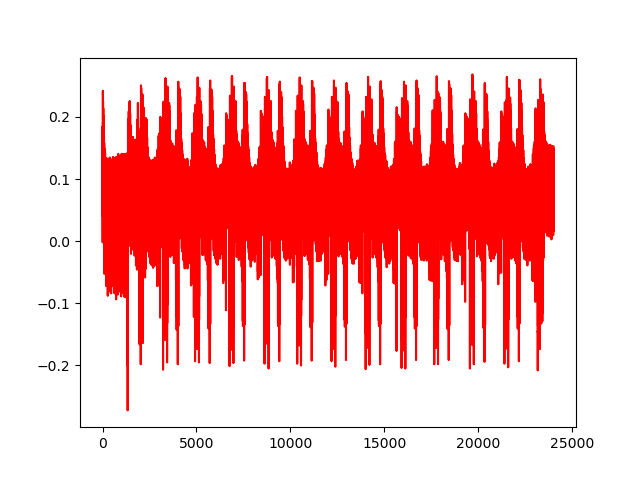

<IPython.core.display.Javascript object>


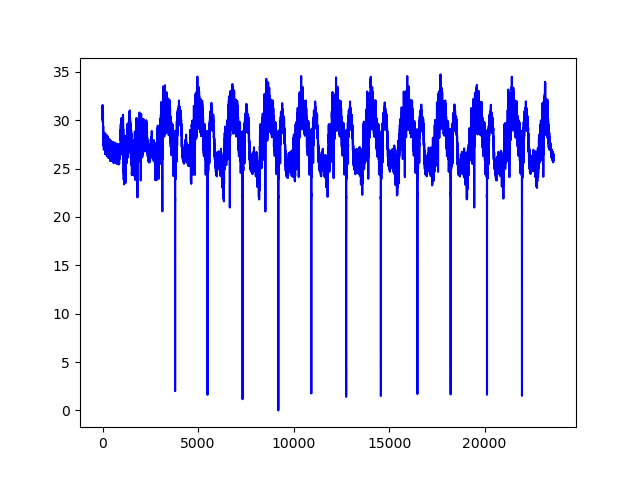

<IPython.core.display.Javascript object>


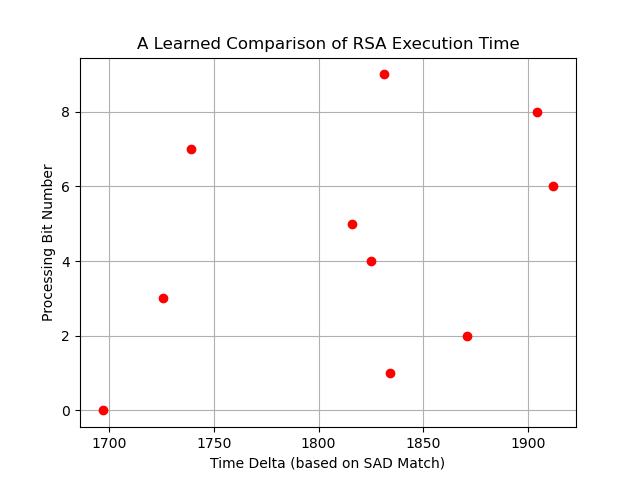

11111111110
I think the real key is : 0x7fe
The real key was: CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 0b 04')


In [17]:
spa_attack(trace,9200,9600,10,800,"0")
print("The real key was: "+str(text))

Sadly as you have noticed, the timing of every pass through the for-loop is too similar now. We can't find usefull thresholds to perform a succesful attack. 

**SUCCES?**

You may have come close by choosing some good parameters but looking at the plots you see that the timings are super close together. So close in fact that the minor differences in timing can be caused by noise.

## Improving the countermeasure even more
Should you still not be satisfied with our countermeasure, we can improve it with another technique. Right before we go to the if statement we generate a random byte. We then run a for loop based on that random value. The length of every pass through the for-loop is now increased by a random amount which makes it harder to compare loop times:

```C
//START EDIT
uint8_t * random;
*random = rand();
for (volatile uint8_t k = 0; k < (*random & 0x0F); k++);
//END EDIT

if(t & (1<<(8-1))){
    bigint_mul_u(&res, &res, &base);
    bigint_reduce(&res, r);
}
//START EDIT
else{
    bigint_mul_u(&res2, &res2, &base2);
    bigint_reduce(&res2, r2pt);
}
//END EDIT
```

If you want to you can try this out in the code block below, but this won't be covered in detail in this notebook (you can use the `+`-buttom in the navigation bar to add codeblocks yourself).

In [ ]:
#You can write some code here if you want.

## Clean up

In [ ]:
scope.dis()
target.dis()

## Next step
Now you know or can:
* come up with a countermeasure
* implement the countermeasure in the source code

In this notebook we were succesful at coming up and implementing a countermeasure against SPA for RSA. In the next notebook we will try to do the same for CPA that attacks AES...

**Next notebook click here: [3_B - Countermeasure to DPA and CPA on AES.ipynb](./3_B%20-%20Countermeasure%20to%20DPA%20and%20CPA%20on%20AES.ipynb)**
